In [1]:
import datetime
import polars as pl # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from upsetplot import UpSet, from_contents # type: ignore
from matplotlib.patches import Patch # type: ignore

In [2]:
rice_idmapping_file_path = "../Data/12_rice_uniprot_idmapping/rice_up_idmapping_all.tsv"
foldseek_result_file_path = "../Data/14_foldseek_result/foldseek_output_uniprot_rice_up_all_evalue01_tmalign.tsv"
main_target_species = 9606
output_tsv_path = "../Data/14_foldseek_result/foldseek_output_uniprot_rice_up_9606_tmalign.tsv"

In [3]:
VERSION = datetime.datetime.now().strftime("%Y%m%d")
print(f"Execute Date: {VERSION}")

Execute Date: 20250527


In [4]:
rice_idmapping = pl.read_csv(
    rice_idmapping_file_path,
    separator='\t'
)

display(rice_idmapping)

From,UniProt Accession
str,str
"""Os01g0105800""","""A0A8J8YF34"""
"""Os01g0105800""","""Q657Z2"""
"""Os01g0124000""","""Q5ZCB1"""
"""Os01g0124000""","""Q5ZD53"""
"""Os01g0124100""","""A0A0P0UYB2"""
…,…
"""Os12g0569200""","""C7JA73"""
"""Os12g0569200""","""Q2QND9"""
"""Os12g0600100""","""Q0IM43"""


In [5]:
foldseek_result_all = pl.read_csv(
    foldseek_result_file_path,
    separator='\t'
).with_columns(
    (pl.col("query").str.extract(r"AF-(.*?)-F1", 1).alias("query")), # "?" means non-greedy
    (pl.col("target").str.extract(r"AF-(.*?)-F1", 1).alias("target"))
).rename(
    {
        "query" : "UniProt Accession",
        "target" : "foldseek hit"
    }
)

foldseek_result_all_v2 = rice_idmapping.join(   
    foldseek_result_all,
    on="UniProt Accession",
    how="left",
    coalesce=True,
    validate="1:m"
)

foldseek_result_all_hit = foldseek_result_all_v2.filter(
    pl.col("foldseek hit").is_not_null()
)

display(foldseek_result_all_hit)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0105800""","""Q657Z2""","""Q8LBM4""",0.8103,0.984,2,72.3,0.723,89,17,137,138,13,135,137,123,0.877,0.898,0.9214,0.8178,0.8235,0.8235,2.063,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""SAHKQKQKQALALTDAAASRIRQLLSLRHR…","""RVGPALRKQVLTLTDEAASRVHHLLQQRQK…",32,"""0.318,0.575,0.614,0.609,0.750,…"
"""Os01g0105800""","""Q657Z2""","""A0A178VZM6""",0.81,0.941,0,68.2,0.682,71,22,125,138,1,104,109,104,0.754,0.954,0.9241,0.7232,0.9107,0.9107,1.596,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""KQKQALALTDAAASRIRQLLSLRHRPYLRL…","""MRKQVLALSDTAAARIRQLLQHQQKPFLRL…",33,"""0.329,0.554,0.617,0.726,0.964,…"
"""Os01g0105800""","""Q657Z2""","""Q8L8C0""",0.8076,0.941,1,71.1,0.711,74,22,125,138,1,103,109,104,0.754,0.945,0.9277,0.7202,0.9078,0.9078,1.469,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""KQKQALALTDAAASRIRQLLSLRHRPYLRL…","""MRKQVLALSDTAAARIRQLLQHQQKPFLRL…",29,"""0.342,0.500,0.575,0.690,0.974,…"
"""Os01g0105800""","""Q657Z2""","""A0A5S9X4E5""",0.8074,0.941,0,68.2,0.682,71,22,125,138,1,104,109,104,0.754,0.954,0.9207,0.7213,0.9083,0.9083,1.699,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""KQKQALALTDAAASRIRQLLSLRHRPYLRL…","""MRKQVLALSDTAAARIRQLLQHQQKPFLRL…",33,"""0.329,0.533,0.583,0.702,0.969,…"
"""Os01g0105800""","""Q657Z2""","""C0P6E8""",0.8048,0.978,7,77.4,0.774,103,13,138,138,1,130,130,133,0.913,1.0,0.8737,0.7963,0.8426,0.8426,2.59,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""RATSSAHK-Q--K-QKQALALTDAAASRIR…","""MSSSVLRAAADRAIRRQALTLTNAAVSRIR…",20,"""0.361,0.325,0.525,0.525,0.614,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""gene-orf224""","""Q35317""","""A0A0G2JFC9""",0.1234,0.016,16,0.0,0.0,0,76,222,224,182,598,619,503,0.656,0.674,0.4897,0.1829,0.07835,0.07835,5.402,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""R-RRREAFS-STLIGSFSGLFSFFFVEGPE…","""EK-EKALQTQVQCQQQHEQQKKEL-ETLHQ…",61,"""0.193,0.225,0.267,0.338,0.368,…"
"""gene-orf224""","""Q35317""","""Q80UK7""",0.1208,0.014,15,3.0,0.03,6,12,114,224,11,170,654,199,0.46,0.245,0.372,0.1828,0.07608,0.07608,5.832,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""QFFWFCLLLVSS---SRGMGGQIPSISRYE…","""PL--LVK-CKDCEER---------------…",58,"""0.109,0.190,0.122,0.244,0.213,…"
"""gene-orf224""","""Q35317""","""A0A067XG49""",0.1143,0.014,10,0.0,0.0,0,79,224,224,184,302,737,208,0.652,0.161,0.5146,0.1771,0.06411,0.06411,5.018,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""REAFS-STLIGSFSGLFSFFFVEGPEVASA…","""KKKQVYVDKVEKMQQALVQLQAACEKREQL…",57,"""0.167,0.294,0.368,0.348,0.432,…"


&nbsp;

&nbsp;

&nbsp;

### No Hit Genes in All Set Species

In [21]:
no_hit = foldseek_result_all_v2.filter(
    pl.col("foldseek hit").is_null()
).select(
    ["From", "UniProt Accession"]
).with_columns(
    pl.col("From").is_in(foldseek_result_all_hit["From"]).alias("exists_in_hit")
)

all_no_hit = no_hit.filter(
    pl.col("exists_in_hit") == False
).sort(
    ["From"], descending=False
)

print(all_no_hit.group_by("From").n_unique())
display(all_no_hit)

shape: (80, 3)
┌──────────────┬───────────────────┬───────────────┐
│ From         ┆ UniProt Accession ┆ exists_in_hit │
│ ---          ┆ ---               ┆ ---           │
│ str          ┆ u32               ┆ u32           │
╞══════════════╪═══════════════════╪═══════════════╡
│ Os02g0733900 ┆ 2                 ┆ 1             │
│ Os06g0146800 ┆ 2                 ┆ 1             │
│ Os07g0652900 ┆ 1                 ┆ 1             │
│ Os09g0272600 ┆ 2                 ┆ 1             │
│ Os09g0425400 ┆ 2                 ┆ 1             │
│ …            ┆ …                 ┆ …             │
│ Os02g0622500 ┆ 1                 ┆ 1             │
│ Os05g0200601 ┆ 1                 ┆ 1             │
│ Os01g0719400 ┆ 2                 ┆ 1             │
│ Os09g0515550 ┆ 1                 ┆ 1             │
│ Os06g0317100 ┆ 1                 ┆ 1             │
└──────────────┴───────────────────┴───────────────┘


From,UniProt Accession,exists_in_hit
str,str,bool
"""Os01g0136050""","""A0A0P0UXN9""",false
"""Os01g0386500""","""A0A0P0V2U1""",false
"""Os01g0594650""","""A0A0P0V4S8""",false
"""Os01g0715201""","""A0A0P0V7E4""",false
"""Os01g0719125""","""A0A0P0V7I7""",false
…,…,…
"""Os11g0601950""","""A0A0P0Y463""",false
"""Os11g0707100""","""A0A0P0Y5Q1""",false
"""Os12g0255850""","""A0A0P0Y8Y1""",false


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# Foldseek result (Human)

In [22]:
foldseek_result_human = foldseek_result_all_hit.filter(
    pl.col("taxid").is_in([main_target_species])
)

display(foldseek_result_human)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0105800""","""Q657Z2""","""A0A1B0GTK6""",0.7736,0.817,2,46.2,0.462,43,23,114,138,1,92,92,93,0.667,1.0,0.8345,0.6354,0.9395,0.9395,1.084,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""QKQALALTDAAASRIRQLLSLRH-RPYLRL…","""MMV-FVTTPSAVNKIKQLLKDKPEHVGVKV…",48,"""0.293,0.425,0.494,0.681,0.841,…"
"""Os01g0105800""","""Q657Z2""","""Q9BUE6""",0.7425,0.941,1,51.8,0.518,56,19,125,138,17,124,129,108,0.775,0.837,0.8944,0.7278,0.7768,0.7768,1.964,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""HKQKQKQALALTDAAASRIRQLLSLRH-RP…","""KLQPTRAALTLTPSAVNKIKQLLKDKPEHV…",51,"""0.432,0.375,0.536,0.645,0.674,…"
"""Os01g0105800""","""Q657Z2""","""Q86U28""",0.6057,0.837,2,27.5,0.275,30,16,123,138,39,145,154,109,0.783,0.695,0.7828,0.6551,0.5931,0.5931,3.018,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""SSAHKQKQKQALALTDAAASRIRQLLSLRH…","""SSSSPEAGEGQIRLTDSCVQRLLEITE--G…",76,"""0.300,0.545,0.675,0.705,0.469,…"
"""Os01g0105800""","""Q657Z2""","""Q5TBE9""",0.5569,0.277,1,41.7,0.417,28,22,87,138,20,86,86,67,0.478,0.779,0.6356,0.4467,0.6983,0.6983,1.712,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""KQKQALALTDAAASRIRQLLSLRH-RPYLR…","""PTRAALTLTPSAVNKIKQLLKDKPEHVGVK…",38,"""0.329,0.326,0.400,0.405,0.448,…"
"""Os01g0135800""","""Q943Q3""","""A0A024R3B9""",0.6343,0.601,6,19.4,0.194,21,44,150,150,1,97,108,108,0.713,0.898,0.6945,0.5622,0.7579,0.7579,2.475,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""WKETPTAHVFTADLPGVRKDQAKVEVEDGG…","""MRLEKDRFSVNLDVKHFSPEELKVKVLG-D…",75,"""0.311,0.424,0.549,0.732,0.790,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""gene-orf224""","""Q35317""","""A8K2N7""",0.1476,0.029,22,0.5,0.005,4,5,222,224,18,655,670,776,0.973,0.952,0.4834,0.224,0.09234,0.09234,5.835,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""D--KLTY-FSQFFWFCLLLVSSSRGM--GG…","""LEI--NEK-LR-PQLAEKKQQFRNLKEKCF…",76,"""0.237,0.326,0.257,0.360,0.305,…"
"""gene-orf224""","""Q35317""","""K7EMK7""",0.1407,0.024,22,2.1,0.021,7,7,169,224,459,713,744,333,0.728,0.343,0.3494,0.2194,0.08624,0.08624,6.28,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""LTYFS-----------QFFWFCLLLVSSSR…","""EVVCAVTISGSTQHVYTGGKGCVKV--W--…",78,"""0.239,0.250,0.284,0.314,0.360,…"
"""gene-orf224""","""Q35317""","""Q6AZY7""",0.1337,0.02,8,0.9,0.009,4,3,116,224,77,451,606,426,0.509,0.619,0.5102,0.1978,0.08485,0.08485,4.94,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""Q-----------------------------…","""FRKVDSLSEDISLTQSIYDKKLVLMQKNLQ…",59,"""0.000,0.152,0.344,0.228,0.311,…"


In [23]:
# Calculate hit count (gene level)
hit_count_human = foldseek_result_human.group_by("From").agg(
        (pl.col("foldseek hit").count().alias("hit count (gene level)"))
    ).sort(
        ["hit count (gene level)"], descending=True
    )

display(hit_count_human)

From,hit count (gene level)
str,u32
"""Os08g0442200""",551
"""Os01g0699400""",547
"""Os07g0633200""",505
"""Os12g0600100""",492
"""Os03g0417700""",464
…,…
"""Os02g0773200""",1
"""Os06g0219500""",1
"""Os08g0387050""",1


In [24]:
foldseek_result_human.write_csv(
    output_tsv_path,
    separator='\t'
)

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# Foldseek result (Mouse)

In [25]:
foldseek_result_mouse = foldseek_result_all_hit.filter(
    pl.col("taxid").is_in([10090])
)

display(foldseek_result_mouse)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0105800""","""Q657Z2""","""I3ITR1""",0.7331,0.933,1,52.3,0.523,55,21,124,138,19,123,129,105,0.754,0.814,0.897,0.7176,0.7662,0.7662,1.574,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""QKQKQALALTDAAASRIRQLLSLRH-RPYL…","""QPTRAALTLTPSAVNKIKQLLKDKPEHVGL…",49,"""0.339,0.513,0.543,0.858,0.869,…"
"""Os01g0105800""","""Q657Z2""","""Q9D924""",0.732,0.933,1,52.3,0.523,55,21,124,138,19,123,129,105,0.754,0.814,0.8966,0.7164,0.765,0.765,1.641,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""QKQKQALALTDAAASRIRQLLSLRH-RPYL…","""QPTRAALTLTPSAVNKIKQLLKDKPEHVGL…",49,"""0.357,0.526,0.533,0.808,0.851,…"
"""Os01g0105800""","""Q657Z2""","""Q9DCB8""",0.6044,0.837,6,21.1,0.211,29,3,123,138,23,145,154,137,0.877,0.799,0.7686,0.6552,0.5924,0.5924,3.209,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""SSA--------------ALALALRRATS-S…","""GRLLAVFPRLLTRWETT----------SS-…",78,"""0.292,0.286,0.219,0.150,0.432,…"
"""Os01g0135800""","""Q943Q3""","""Q3UN84""",0.5475,0.382,7,17.3,0.173,17,42,137,150,12,98,110,98,0.64,0.791,0.6213,0.4884,0.6482,0.6482,2.89,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""VDWKE-TPTAHVFTADLPGVRKDQAKVEVE…","""PIRVSTDSGYFSVLLDVKHFLPEEISVKVV…",68,"""0.100,0.463,0.328,0.535,0.514,…"
"""Os01g0135800""","""Q943Q3""","""Q569M7""",0.5321,0.663,11,12.2,0.122,21,16,146,150,13,157,173,172,0.873,0.838,0.686,0.585,0.5136,0.5136,3.14,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""DFWAD-------ADPFGAVRSLAERCPVLT…","""ALGPFYPSRLFD---------------QFF…",83,"""0.071,0.138,0.233,0.156,0.107,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""gene-orf224""","""Q35317""","""Z4YN92""",0.1351,0.014,10,2.0,0.02,6,83,212,224,78,295,406,286,0.58,0.537,0.5779,0.1772,0.1111,0.1111,5.705,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""SSTLIG------------------------…","""KVKTKPEARQELDSSGEWEERKYLLARRRV…",56,"""0.182,0.222,0.213,0.150,0.161,…"
"""gene-orf224""","""Q35317""","""Q3UKC1""",0.1235,0.02,15,1.3,0.013,8,1,162,224,206,718,814,605,0.723,0.63,0.5381,0.1956,0.06797,0.06797,5.959,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""M---PQLDKLTY-FSQ--FFW---------…","""LLEVSQSLRVENE-EFMK--RYSDATAKVQ…",62,"""0.536,0.477,0.538,0.792,0.475,…"
"""gene-orf224""","""Q35317""","""A0A0G2JFC9""",0.1234,0.016,16,0.0,0.0,0,76,222,224,182,598,619,503,0.656,0.674,0.4897,0.1829,0.07835,0.07835,5.402,10090,"""Mus musculus""","""-_cellular organisms;d_Eukaryo…","""R-RRREAFS-STLIGSFSGLFSFFFVEGPE…","""EK-EKALQTQVQCQQQHEQQKKEL-ETLHQ…",61,"""0.193,0.225,0.267,0.338,0.368,…"


In [26]:
# 遺伝子レベルでのヒットカウントを算出
hit_count_mouse = foldseek_result_mouse.group_by("From").agg(
        (pl.col("foldseek hit").count().alias("hit count (gene level)"))
    ).sort(
        ["hit count (gene level)"], descending=True
    )

display(hit_count_mouse)

From,hit count (gene level)
str,u32
"""Os03g0417700""",525
"""Os01g0699400""",392
"""Os12g0600100""",358
"""Os03g0265600""",356
"""Os05g0223200""",349
…,…
"""Os06g0592500""",1
"""Os05g0367000""",1
"""Os10g0335000""",1


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;



# Foldseek result (Arabidopsis)

In [27]:
foldseek_result_arabidopsis = foldseek_result_all_hit.filter(
    pl.col("taxid").is_in([3702])
)

display(foldseek_result_arabidopsis)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0105800""","""Q657Z2""","""Q8LBM4""",0.8103,0.984,2,72.3,0.723,89,17,137,138,13,135,137,123,0.877,0.898,0.9214,0.8178,0.8235,0.8235,2.063,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""SAHKQKQKQALALTDAAASRIRQLLSLRHR…","""RVGPALRKQVLTLTDEAASRVHHLLQQRQK…",32,"""0.318,0.575,0.614,0.609,0.750,…"
"""Os01g0105800""","""Q657Z2""","""A0A178VZM6""",0.81,0.941,0,68.2,0.682,71,22,125,138,1,104,109,104,0.754,0.954,0.9241,0.7232,0.9107,0.9107,1.596,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""KQKQALALTDAAASRIRQLLSLRHRPYLRL…","""MRKQVLALSDTAAARIRQLLQHQQKPFLRL…",33,"""0.329,0.554,0.617,0.726,0.964,…"
"""Os01g0105800""","""Q657Z2""","""Q8L8C0""",0.8076,0.941,1,71.1,0.711,74,22,125,138,1,103,109,104,0.754,0.945,0.9277,0.7202,0.9078,0.9078,1.469,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""KQKQALALTDAAASRIRQLLSLRHRPYLRL…","""MRKQVLALSDTAAARIRQLLQHQQKPFLRL…",29,"""0.342,0.500,0.575,0.690,0.974,…"
"""Os01g0105800""","""Q657Z2""","""A0A5S9X4E5""",0.8074,0.941,0,68.2,0.682,71,22,125,138,1,104,109,104,0.754,0.954,0.9207,0.7213,0.9083,0.9083,1.699,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""KQKQALALTDAAASRIRQLLSLRHRPYLRL…","""MRKQVLALSDTAAARIRQLLQHQQKPFLRL…",33,"""0.329,0.533,0.583,0.702,0.969,…"
"""Os01g0105800""","""Q657Z2""","""Q0WSL3""",0.7609,0.967,0,77.1,0.771,88,20,133,138,16,129,137,114,0.826,0.832,0.9246,0.7685,0.7739,0.7739,1.863,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""KQKQKQALALTDAAASRIRQLLSLRHRPYL…","""PALRKQVLTLTDEAASRVHHLLQQRQKPFL…",26,"""0.469,0.571,0.618,0.750,0.783,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""gene-orf224""","""Q35317""","""A0A1I9LN90""",0.1458,0.014,9,2.7,0.027,6,25,160,224,61,207,315,222,0.607,0.467,0.485,0.1772,0.1355,0.1355,5.546,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""RGMGGQI-------------PSISRYERIV…","""NVLDPERPKNDKATILTDTV----------…",55,"""0.110,0.287,0.200,0.333,0.292,…"
"""gene-orf224""","""Q35317""","""A0A654FHI5""",0.1453,0.011,6,0.6,0.006,2,1,146,224,6,235,284,325,0.652,0.81,0.4938,0.1678,0.1371,0.1371,4.772,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""M--PQLDKLTYFSQFFWFCLLLVSSSRGMG…","""RKSQKAGREKLRREKLNEHFVELGNVLDPE…",49,"""0.857,0.500,0.635,1.000,0.625,…"
"""gene-orf224""","""Q35317""","""A0A178W2G1""",0.1415,0.014,6,4.9,0.049,3,29,80,224,103,163,342,61,0.232,0.178,0.4575,0.1755,0.1224,0.1224,4.08,3702,"""Arabidopsis thaliana""","""-_cellular organisms;d_Eukaryo…","""GQ--IPS-ISRYERIVSKFIGKFF-FS--G…","""LKLEHSLDELKDFKAWFDFLTLNTNVESVS…",49,"""0.271,0.429,0.397,0.425,0.611,…"


In [28]:
hit_count_arabidopsis = foldseek_result_arabidopsis.group_by("From").agg(
    (pl.col("foldseek hit").count().alias("hit count (gene level)"))
).sort(
    ["hit count (gene level)"], descending=True
)

display(hit_count_arabidopsis)

From,hit count (gene level)
str,u32
"""Os03g0417700""",2217
"""Os11g0518600""",880
"""Os06g0593100""",816
"""Os10g0523900""",717
"""Os05g0223200""",667
…,…
"""Os02g0542450""",1
"""Os08g0387050""",1
"""Os03g0724500""",1


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;



# Foldseek result (Maize)

In [29]:
foldseek_result_maize = foldseek_result_all_hit.filter(
    pl.col("taxid").is_in([4577])
)

display(foldseek_result_maize)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0105800""","""Q657Z2""","""C0P6E8""",0.8048,0.978,7,77.4,0.774,103,13,138,138,1,130,130,133,0.913,1.0,0.8737,0.7963,0.8426,0.8426,2.59,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""RATSSAHK-Q--K-QKQALALTDAAASRIR…","""MSSSVLRAAADRAIRRQALTLTNAAVSRIR…",20,"""0.361,0.325,0.525,0.525,0.614,…"
"""Os01g0105800""","""Q657Z2""","""A0A3L6FER6""",0.7789,0.967,3,81.8,0.818,95,14,126,138,3,118,130,116,0.819,0.892,0.9131,0.7644,0.81,0.81,2.22,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""ATSSAHK-Q-K-QKQALALTDAAASRIRQL…","""SSVLRAAADRAIRRQALTLTNAAASRIRQL…",18,"""0.175,0.425,0.450,0.591,0.650,…"
"""Os01g0105800""","""Q657Z2""","""B6SL54""",0.7706,0.961,5,77.3,0.773,92,15,128,138,4,119,130,119,0.826,0.892,0.9159,0.7561,0.8014,0.8014,2.02,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""T--SSAH--KQK-QKQALALTDAAASRIRQ…","""SVL--RAAADRAIRRQALTLTDAAASRIRQ…",19,"""0.125,0.475,0.523,0.500,0.464,…"
"""Os01g0105800""","""Q657Z2""","""A0A3L6DN23""",0.7701,0.961,5,78.6,0.786,92,18,130,138,7,121,130,117,0.819,0.885,0.9153,0.7548,0.8,0.8,2.042,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""AH-KQK--QKQALALTDAAASRIRQLLSLR…","""RAAADRAIRRQALTLTDAAASRIRQLLSLR…",19,"""0.325,0.455,0.297,0.643,0.763,…"
"""Os01g0105800""","""Q657Z2""","""B6T2F8""",0.7671,0.961,5,81.1,0.811,95,15,126,138,4,118,130,117,0.812,0.885,0.9169,0.7517,0.7967,0.7967,1.956,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""T--SSAHK-Q-K-QKQALALTDAAASRIRQ…","""SVL--RAAADRAIRRQALTLTNAAASRIRQ…",15,"""0.100,0.450,0.591,0.500,0.607,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""gene-orf224""","""Q35317""","""A0A1D6FYU2""",0.1362,0.029,22,0.5,0.005,3,1,159,224,279,870,875,674,0.71,0.677,0.3775,0.2195,0.07094,0.07094,5.826,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""M-----------------------------…","""FWYPGLSCLIIGIKTEINPILTPRAAGPEG…",74,"""0.000,0.160,0.200,0.188,0.350,…"
"""gene-orf224""","""Q35317""","""B6SWF5""",0.1313,0.016,10,0.4,0.004,2,78,196,224,113,463,521,413,0.531,0.674,0.5364,0.186,0.08955,0.08955,4.869,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""RR--EAFS-STLIGSFSGLFSFFFVEGPEV…","""NFQCLDKQVKEVQKSVQVVQERQELAETQK…",55,"""0.213,0.333,0.250,0.412,0.424,…"
"""gene-orf224""","""Q35317""","""A0A1D6G1B0""",0.1312,0.016,12,1.0,0.01,6,14,147,224,44,542,578,569,0.598,0.863,0.4997,0.1916,0.08709,0.08709,5.466,4577,"""Zea mays""","""-_cellular organisms;d_Eukaryo…","""FWFCLLLVSSSR----------------GM…","""LQDGRLVRTFVAAYGQPPPPQQQQQQQD--…",58,"""0.243,0.408,0.304,0.250,0.368,…"


In [30]:
hit_count_count_maize = foldseek_result_maize.group_by("From").agg(
    (pl.col("foldseek hit").count().alias("hit count (gene level)"))
).sort(
    ["hit count (gene level)"], descending=True
)

display(hit_count_count_maize)

From,hit count (gene level)
str,u32
"""Os03g0417700""",1586
"""Os07g0549800""",1123
"""Os03g0265600""",1053
"""Os11g0518600""",1028
"""Os07g0633200""",1015
…,…
"""Os04g0112533""",1
"""Os03g0286900""",1
"""Os03g0623100""",1


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;



# Foldseek result (Oryza rufipogon)

In [31]:
foldseek_result_oryza_rufipogon = foldseek_result_all_hit.filter(
    pl.col("taxid").is_in([4529])
)

display(foldseek_result_oryza_rufipogon)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0105800""","""Q657Z2""","""A0A0E0RHD5""",0.7654,0.967,0,84.8,0.848,95,18,129,138,13,124,133,112,0.812,0.842,0.9408,0.7599,0.7876,0.7876,2.14,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""AHKQKQKQALALTDAAASRIRQLLSLRHRP…","""AGPSVRKQALTLTDAAASRVRQLLGVRQRA…",17,"""0.475,0.545,0.641,0.732,0.855,…"
"""Os01g0105800""","""Q657Z2""","""A0A0E0MQC3""",0.6639,0.941,2,78.4,0.784,102,20,123,138,20,149,164,130,0.754,0.793,0.9312,0.7257,0.6128,0.6128,1.425,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""KQKQKQALALTDAAASRIRQLLSLRHRPYL…","""KQKQKQALALTDAAASRIRQLLSLRHRPYL…",2,"""0.281,0.589,0.618,0.815,0.867,…"
"""Os01g0105800""","""Q657Z2""","""A0A0E0QI32""",0.6594,0.772,3,25.6,0.256,28,29,122,138,1,109,115,109,0.681,0.948,0.7433,0.6203,0.7357,0.7357,2.009,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""LTDAAASRIRQLLSLR-HR--PYLRLGVKA…","""MTDGCIRRLKELHAKEPPSEGKMLRLSVEA…",66,"""0.716,0.821,0.902,0.904,0.880,…"
"""Os01g0105800""","""Q657Z2""","""A0A0E0QI72""",0.6089,0.855,3,31.4,0.314,34,20,123,138,41,148,156,108,0.754,0.692,0.7875,0.6644,0.5935,0.5935,2.236,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""KQKQKQALALTDAAASRIRQLLSLRH--RP…","""SPADPDTLHMTDGCIRRLKELHAKEPPSEG…",70,"""0.406,0.500,0.566,0.511,0.642,…"
"""Os01g0105800""","""Q657Z2""","""A0A0E0PTI0""",0.5935,0.9,3,32.7,0.327,36,17,123,138,57,166,186,110,0.775,0.591,0.7826,0.6934,0.5242,0.5242,2.31,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""SAHKQKQKQALALTDAAASRIRQLLSLR-H…","""ATTSGSIAPAISLTEKALKHLNKMRAERNE…",71,"""0.364,0.475,0.500,0.688,0.625,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""gene-orf224""","""Q35317""","""S6CDE1""",0.5136,0.505,8,43.4,0.434,119,2,206,224,2,207,224,274,0.915,0.92,0.8056,0.5256,0.5256,0.5256,3.569,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""PQLDKLTYFSQFFWFCLLLVSSSRGMGGQI…","""PKLDKLTYFSQFFWFCLLLVSSSRGMGGQI…",18,"""0.477,0.519,0.708,0.863,0.793,…"
"""gene-orf224""","""Q35317""","""A0A0E0NC48""",0.2008,0.029,13,2.1,0.021,6,28,219,224,51,207,235,276,0.857,0.668,0.5073,0.22,0.2118,0.2118,5.317,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""G-----GQIPSISRYERIVSKFIGKFFFSG…","""AYQKMA------------------------…",67,"""0.033,0.261,0.177,0.287,0.383,…"
"""gene-orf224""","""Q35317""","""A0A0E0Q224""",0.1968,0.029,11,1.6,0.016,5,3,161,224,3,217,243,301,0.71,0.885,0.5008,0.2182,0.2047,0.2047,5.32,4529,"""Oryza rufipogon""","""-_cellular organisms;d_Eukaryo…","""QLDKLTYFSQFFWFCLLLVSSSRGM--GG-…","""CK-LSGMATDLFGLHRILSSLLEIEGTRTT…",68,"""0.327,0.542,0.241,0.359,0.522,…"


In [32]:
hit_count_oryza_rufipogon = foldseek_result_oryza_rufipogon.group_by("From").agg(
    (pl.col("foldseek hit").count().alias("hit count (gene level)"))
).sort(
    ["hit count (gene level)"], descending=True
)

display(hit_count_oryza_rufipogon)

From,hit count (gene level)
str,u32
"""Os03g0417700""",488
"""Os11g0518600""",217
"""Os08g0442200""",183
"""Os06g0593100""",177
"""Os10g0523900""",165
…,…
"""Os10g0173000""",1
"""Os03g0133100""",1
"""Os08g0104400""",1


&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

## Upset plot

In [33]:
species_contents = {
    'Homo sapiens': hit_count_human["From"].to_list(),
    'Mus musculus': hit_count_mouse["From"].to_list(),
    'Arabidopsis thaliana': hit_count_arabidopsis["From"].to_list(),
    'Zea mays': hit_count_count_maize["From"].to_list(),
    'Oryza rufipogon': hit_count_oryza_rufipogon["From"].to_list(),
    'rice all genes': rice_idmapping["From"].unique().to_list()
}

upset_data = from_contents(species_contents)
display(upset_data)

/usr/local/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


id
Homo sapiens Mus musculus Arabidopsis thaliana Zea mays Oryza rufipogon rice all genes              
True         True         True                 True     True            True            Os08g0442200
                                                                        True            Os01g0699400
                                                                        True            Os07g0633200
                                                                        True            Os12g0600100
                                                                        True            Os03g0417700
...                                                                                              ...
False        False        False                False    False           True            Os01g0386500
                                                                        True            Os08g0444440
                                                                        True            Os05g0121750
                                                                        True            Os03g0113750
                                                                        True            Os01g0136050

[367 rows x 1 columns]

In [34]:
upset_data.to_csv(
    "../Data/15_foldseek_result_upset/rice_up_all_upset_data_tmalign.tsv",
    sep="\t",
    index=True
)

/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

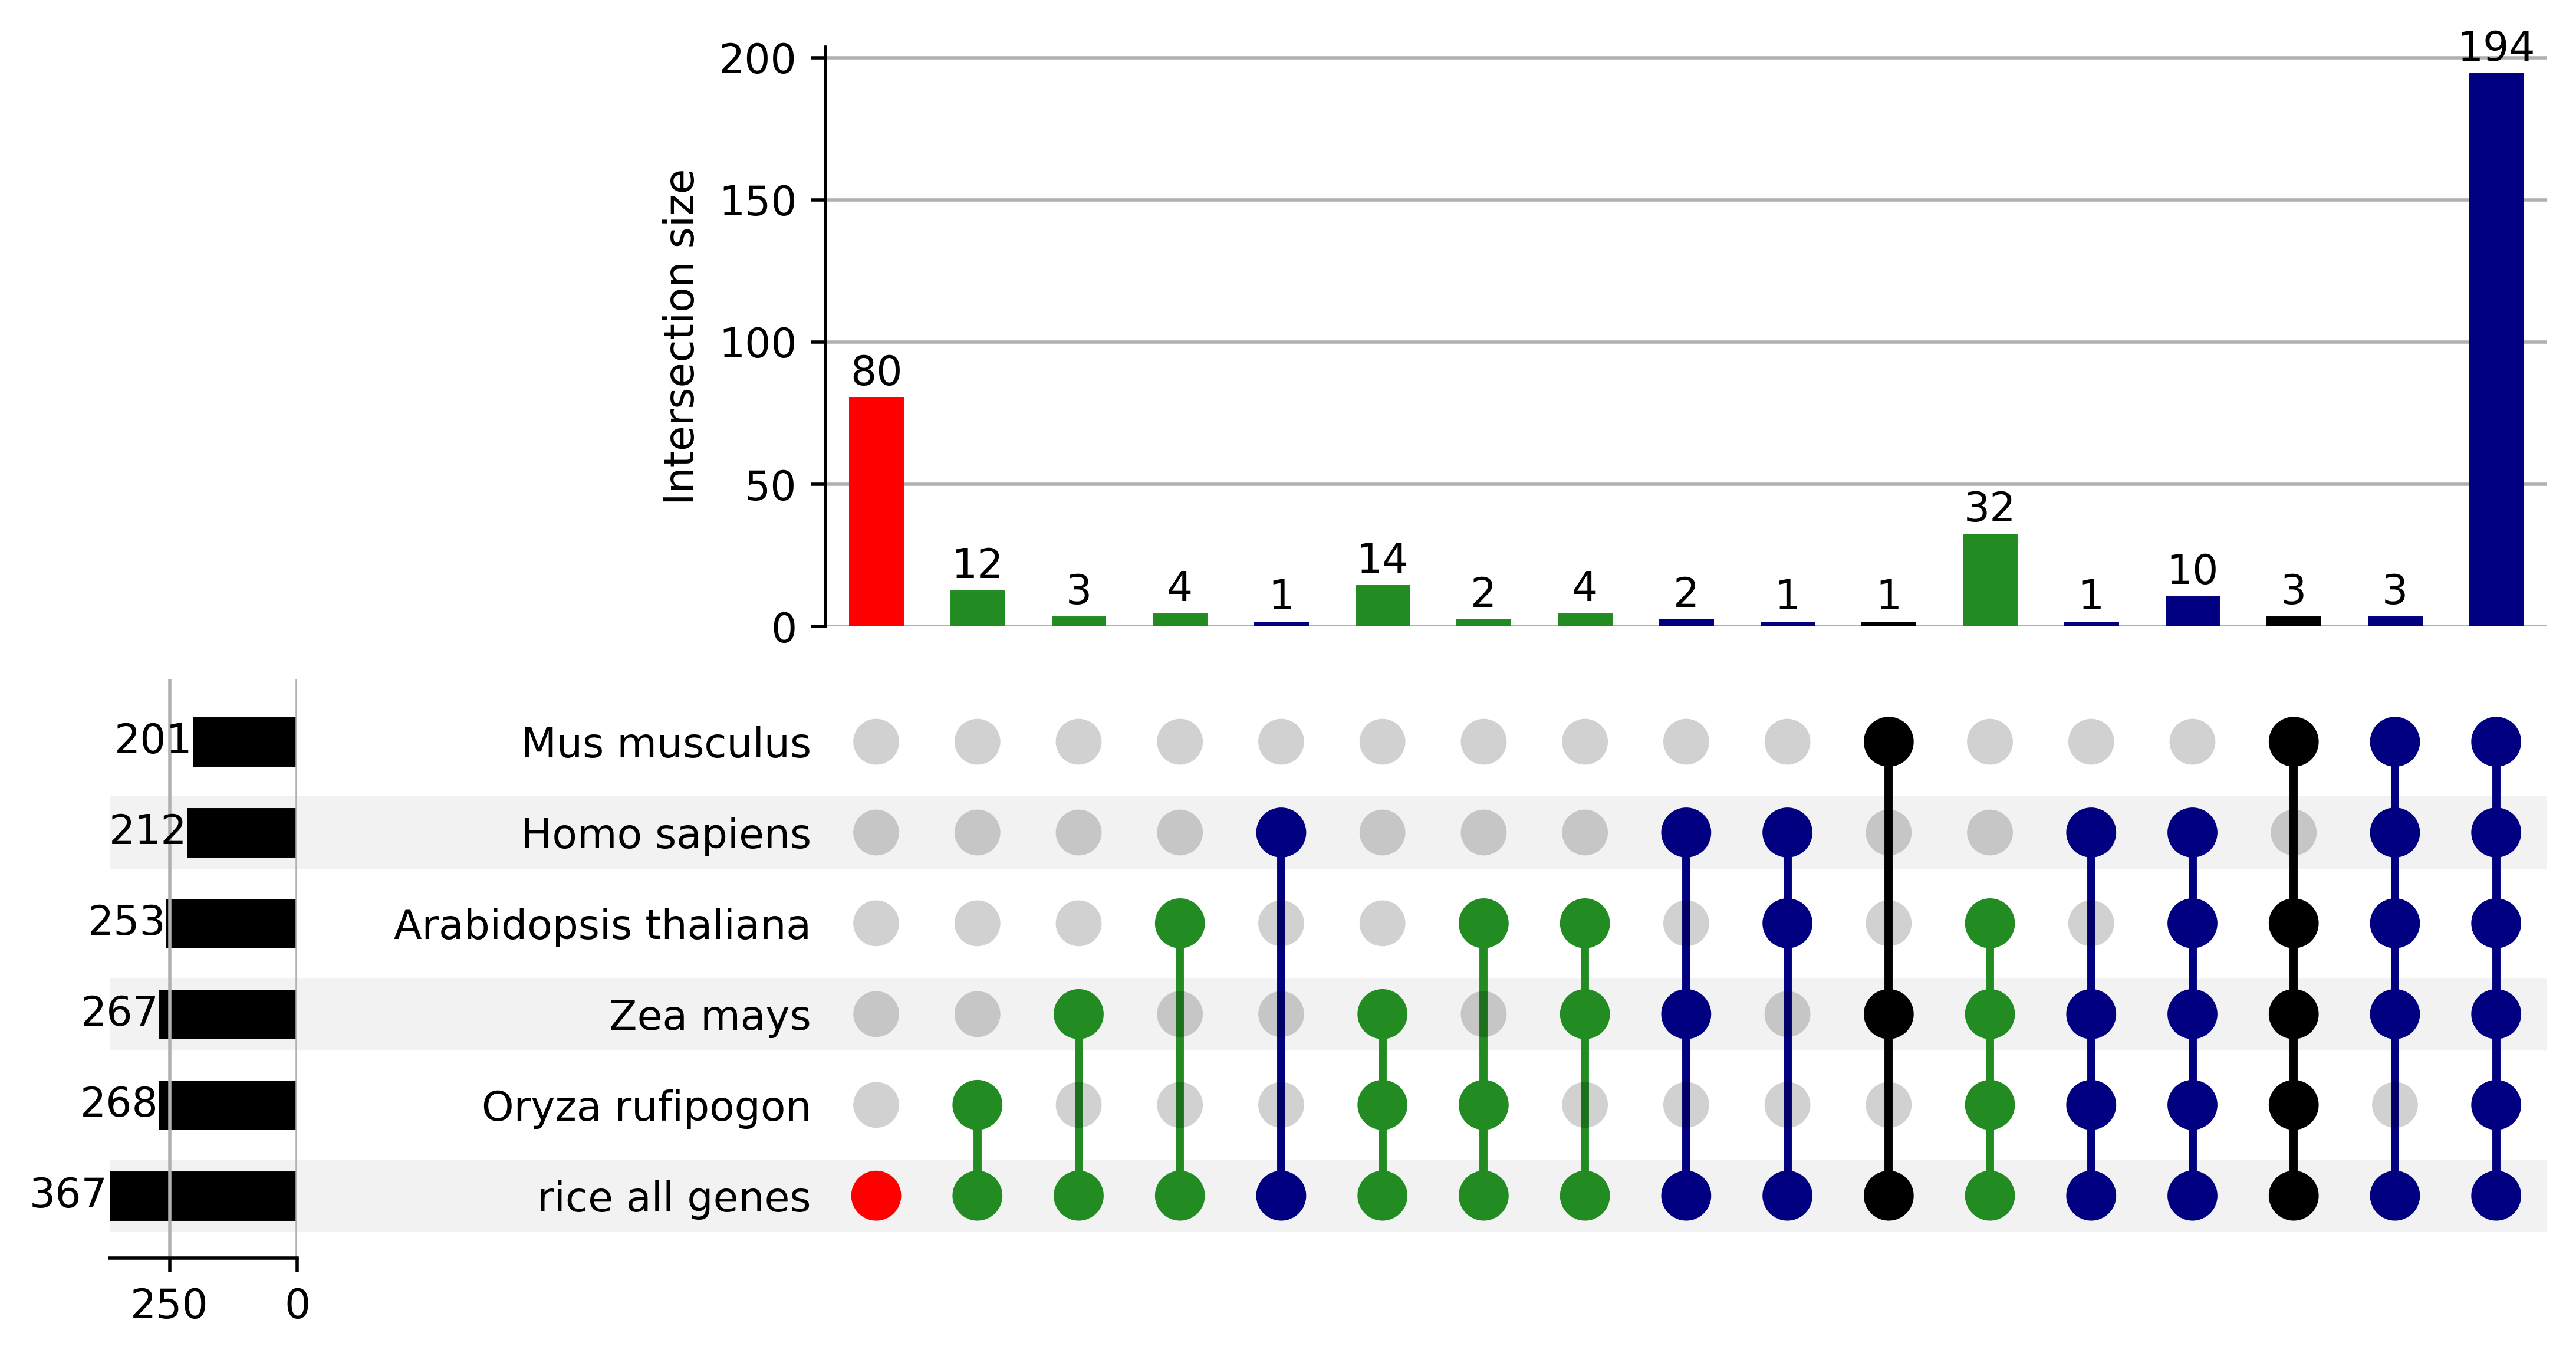

In [35]:
upset_plot = UpSet(
    upset_data,
    orientation='horizontal',
    show_counts="{:d}",
    subset_size='count',
    include_empty_subsets = False
)

upset_plot.style_subsets(present="Homo sapiens", 
                         facecolor="navy"
                         )

upset_plot.style_subsets(absent=["Homo sapiens", "Mus musculus"], 
                         facecolor="forestgreen"
                         )

upset_plot.style_subsets(absent=["Homo sapiens", "Mus musculus", "Arabidopsis thaliana", "Zea mays", "Oryza rufipogon"], 
                         facecolor="red"
                         )

fig = plt.figure(figsize=(14, 8), dpi=500)
upset_plot.plot(fig=fig)
plt.show()

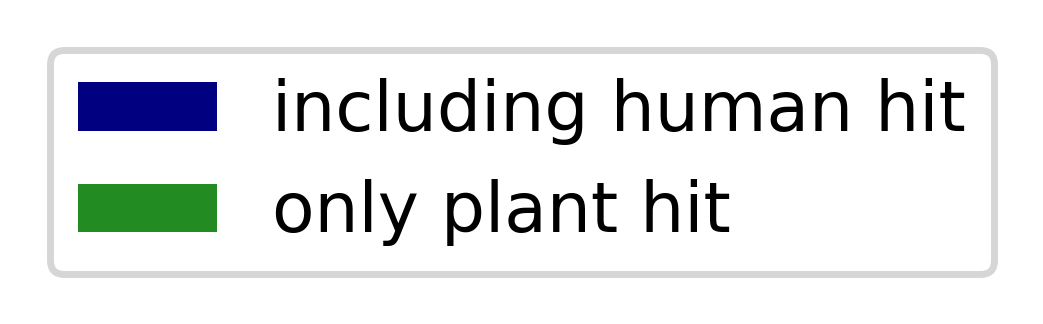

In [36]:
# Create legend independently
legend_elements = [
    Patch(facecolor="navy", label="including human hit"),
    Patch(facecolor='forestgreen', label='only plant hit')
]

fig_leg = plt.figure(figsize=(1.5, 0.5), dpi=500)
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles=legend_elements, loc='center')
ax_leg.axis('off') 
plt.show()
# fig_leg.savefig('legend.png', bbox_inches='tight')